In this note bookbook aims to build a model for Kannada MNIST dataset.

I am basing this on my earlier wor of Bengali AI. However instead of converting a grayscale to 3-channel image, I plan to modify the pre-trained architecture to accept 1-channel images

In [1]:
%matplotlib inline 
# If we don't do this then image will open as pop-up and not in notebook

In [2]:
import pandas as pd
import numpy as np
from PIL import Image as Image
import matplotlib as plt
import matplotlib.pyplot as pyplt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow

In [33]:
from skimage import io

In [3]:
import wget
import time
import os
import copy

In [4]:
path =  '/home/ubuntu/datasets/kannada-MNIST/'
!ls -l $path

total 143380
-rw-r--r-- 1 ubuntu ubuntu  18401187 Sep 16 22:42 Dig-MNIST.csv
-rw-r--r-- 1 ubuntu ubuntu      9253 Feb  1 17:00 file.png
-rw-rw-r-- 1 ubuntu ubuntu  13014944 Jan 31 16:21 Kannada-MNIST.zip
drwxr-xr-x 2 ubuntu ubuntu    126976 Jan 31 17:45 kannada_test_224by224
drwxr-xr-x 2 ubuntu ubuntu   1798144 Jan 31 17:41 kannada_train_224by224
-rw-r--r-- 1 ubuntu ubuntu     33899 Sep 16 22:42 sample_submission.csv
drwxr-xr-x 2 ubuntu ubuntu      4096 Feb  1 17:55 test
-rw-r--r-- 1 ubuntu ubuntu   8667163 Sep 16 22:42 test.csv
-rw-r--r-- 1 ubuntu ubuntu 104748945 Sep 16 22:42 train.csv


### Sample Submission File

In [101]:
sample_submission = pd.read_csv(path+"/sample_submission.csv")

In [102]:
sample_submission.shape

(5000, 2)

In [103]:
sample_submission.head(10)

,id,label
0,0,5
1,1,5
2,2,5
3,3,5
4,4,5
5,5,5
6,6,5
7,7,5
8,8,5
9,9,5


In [104]:
actual_submission = sample_submission

### The Train Files

In [9]:
# Training label files
train = pd.read_csv(path+"/train.csv")

In [10]:
train.shape

(60000, 785)

In [11]:
train_labels = train.iloc[:,:1]

In [12]:
train_labels.head()

,label
0,0
1,1
2,2
3,3
4,4


In [13]:
train_labels['label'].unique(), len(train_labels['label'])

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 60000)

^ Everything looks good.

In [14]:
train_labels['label'][25], train_labels['label'][72]

(5, 2)

In [15]:
del train

### Getting the data ready

In [16]:
# PyTorch databuild libraries and modules
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
#import cv2

In [17]:
im = mpimg.imread('/home/ubuntu/datasets/kannada-MNIST/kannada_train_224by224/10001.png')

In [18]:
type(im), im.shape

(numpy.ndarray, (224, 224))

In [19]:
im = mpimg.imread('/home/ubuntu/datasets/kannada-MNIST/kannada_test_224by224/4500.png')

In [20]:
type(im), im.shape

(numpy.ndarray, (224, 224))

In [21]:
im

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

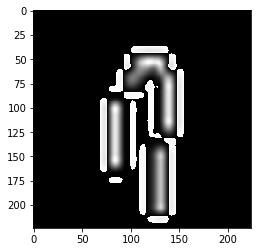

In [22]:
pyplt.imshow(im, cmap = pyplt.get_cmap('gray'))

Let's adjust the resnet model we plan to use to accept a one channel image as input. Additionally we can change number of classed to 10.

In [27]:
class KannadaMnistDataset(Dataset):
    """Kannada language handwritten character dataset."""
    
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): directory path of folder with image data.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):        
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_id = str(idx)
        img_name = image_id+'.png'
        img_label = train_labels['label'][idx]
                        
        img_path = os.path.join(self.root_dir,img_name)
        image = mpimg.imread(img_path)
                
        if self.transform:
            image = self.transform(Image.fromarray(image))
            # sample = {'img_label': img_label, 'image': img_data}

        return image, img_label

In [28]:
# Now let's create a PyTorch Dataset object with transformations
transformed_dataset = KannadaMnistDataset(root_dir='/home/ubuntu/datasets/kannada-MNIST/kannada_train_224by224/',
                                           transform=transforms.Compose([
                                               transforms.ToTensor(),
                                               #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                               transforms.Normalize([0.0692], [0.2051])
                                           ]))

In [29]:
tt = transformed_dataset.__getitem__(65)

In [30]:
len(tt), tt

(2, (tensor([[[-0.3374, -0.3374, -0.3374,  ..., -0.3374, -0.3374, -0.3374],
           [-0.3374, -0.3374, -0.3374,  ..., -0.3374, -0.3374, -0.3374],
           [-0.3374, -0.3374, -0.3374,  ..., -0.3374, -0.3374, -0.3374],
           ...,
           [-0.3374, -0.3374, -0.3374,  ..., -0.3374, -0.3374, -0.3374],
           [-0.3374, -0.3374, -0.3374,  ..., -0.3374, -0.3374, -0.3374],
           [-0.3374, -0.3374, -0.3374,  ..., -0.3374, -0.3374, -0.3374]]]), 5))

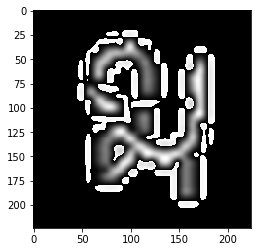

In [31]:
# to_pil = transforms.ToPILImage() 
imshow(tt[0][0], cmap='gray')

In [32]:
tt[0].shape

torch.Size([1, 224, 224])

In [34]:
tt[0].shape, tt[0].max(), tt[0].min()

(torch.Size([1, 224, 224]), tensor(4.5383), tensor(-0.3374))

### Creating a validation dataset from training data

In [35]:
train_size = int(0.8 * len(transformed_dataset))
val_size = len(transformed_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(transformed_dataset, [train_size, val_size])

In [36]:
len(train_dataset), len(val_dataset)

(48000, 12000)

In [37]:
model_data = {}
model_data['train'] = train_dataset
model_data['val'] = val_dataset

### Getting the dataloader ready

Within a Python process, the Global Interpreter Lock (GIL) prevents true fully parallelizing Python code across threads. To avoid blocking computation code with data loading, PyTorch provides an easy switch to perform multi-process data loading by simply setting the argument num_workers to a positive integer.

In [38]:
dataloaders = {x: DataLoader(model_data[x], 
                             batch_size=16,
                             #shuffle=True, 
                             num_workers=4)
              for x in ['train', 'val']}

In [39]:
len(dataloaders['train'].dataset), len(dataloaders['val'].dataset), len(dataloaders['train']), len(dataloaders['val'])

(48000, 12000, 3000, 750)

In [40]:
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}

In [41]:
# class_names = dataloaders['train'].dataset.
dataset_sizes['train'], dataset_sizes['val']

(48000, 12000)

In [42]:
len(dataloaders['train'].dataset), len(dataloaders['val'].dataset)

(48000, 12000)

In [56]:
class resnet18_grsc(models.resnet.ResNet):

    def __init__(self, block, layers, num_classes=10, **kwargs):
        self.inplanes = 64
        super(resnet18_grsc, self).__init__(block, layers)
        #uper(resnet18_grsc, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        for key, value in kwargs.items():
            setattr(self, key, value)

In [63]:
class resnet_grsc(models.resnet.ResNet):

    def __init__(self, block, layers, num_classes=10, **kwargs):
        self.inplanes = 64
        super(resnet_grsc, self).__init__(block, layers)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        for key, value in kwargs.items():
            setattr(self, key, value)

In [45]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            start_time = time.time()
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            end_time = time.time()
            hours, rem = divmod(end_time-start_time, 3600)
            minutes, seconds = divmod(rem, 60)
            print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [46]:
# PyTorch libraries and modules
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.optim as optim
import torch

In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [65]:
# Load a pretrained model and reset final fully connected layer.

# The 4 numbers below specifies the layers argument to create different resnet architectures as seen here: 
# https://github.com/pytorch/vision/blob/791c172a337d98012018f98ffde93b1020ba3ed5/torchvision/models/resnet.py#L236
model_ft = resnet_grsc(models.resnet.Bottleneck, [3, 8, 36, 3])

num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)

# Ensuring the model is using GPU
model_ft = model_ft.to(device)

# As we have two classes (0 or 1) we will use cross-entropy as criterion
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [64]:
# Approach 1: Resnet18 with Grayscale

In [66]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.3770 Acc: 0.8725
00:11:49.49
val Loss: 0.0712 Acc: 0.9803
00:00:56.69

Epoch 1/4
----------
train Loss: 0.0674 Acc: 0.9795
00:11:46.18
val Loss: 0.0441 Acc: 0.9871
00:00:58.05

Epoch 2/4
----------
train Loss: 0.0366 Acc: 0.9892
00:11:47.70
val Loss: 0.0319 Acc: 0.9914
00:00:56.91

Epoch 3/4
----------
train Loss: 0.0158 Acc: 0.9956
00:11:42.56
val Loss: 0.0305 Acc: 0.9918
00:00:56.92

Epoch 4/4
----------
train Loss: 0.0044 Acc: 0.9993
00:11:44.16
val Loss: 0.0258 Acc: 0.9935
00:00:57.00

Training complete in 63m 36s
Best val Acc: 0.993500


In [67]:
torch.save(model_ft, '/home/ubuntu/codebase/my_github/kaggle-competitions/kannada-MNIST/resnet152-grayscale-kannada-MNIST.pth')

### Test data

In [68]:
class KannadaMnistDataset(Dataset):
    """Kannada language handwritten character dataset."""
    
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): directory path of folder with image data.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):        
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_id = str(idx)
        img_name = image_id+'.png'
        #img_label = train_labels['label'][idx]
                        
        img_path = os.path.join(self.root_dir,img_name)
        image = mpimg.imread(img_path)
                
        if self.transform:
            image = self.transform(Image.fromarray(image))
            # sample = {'img_label': img_label, 'image': img_data}

        return image, image_id

In [69]:
transformed_data = KannadaMnistDataset('/home/ubuntu/datasets/kannada-MNIST/kannada_test_224by224/',
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize([0.0692], [0.2051])
                   ]))

In [70]:
tt = transformed_data.__getitem__(0)

In [71]:
tt

(tensor([[[-0.3374, -0.3374, -0.3374,  ..., -0.3374, -0.3374, -0.3374],
          [-0.3374, -0.3374, -0.3374,  ..., -0.3374, -0.3374, -0.3374],
          [-0.3374, -0.3374, -0.3374,  ..., -0.3374, -0.3374, -0.3374],
          ...,
          [-0.3374, -0.3374, -0.3374,  ..., -0.3374, -0.3374, -0.3374],
          [-0.3374, -0.3374, -0.3374,  ..., -0.3374, -0.3374, -0.3374],
          [-0.3374, -0.3374, -0.3374,  ..., -0.3374, -0.3374, -0.3374]]]), '0')

In [72]:
tt[0].shape

torch.Size([1, 224, 224])

In [73]:
test_dataloader = DataLoader(transformed_data, 
                             batch_size=16,
                             #shuffle=True, 
                             num_workers=2)

In [74]:
len(test_dataloader)

313

In [75]:
test_dataloader.dataset.__getitem__(0)

(tensor([[[-0.3374, -0.3374, -0.3374,  ..., -0.3374, -0.3374, -0.3374],
          [-0.3374, -0.3374, -0.3374,  ..., -0.3374, -0.3374, -0.3374],
          [-0.3374, -0.3374, -0.3374,  ..., -0.3374, -0.3374, -0.3374],
          ...,
          [-0.3374, -0.3374, -0.3374,  ..., -0.3374, -0.3374, -0.3374],
          [-0.3374, -0.3374, -0.3374,  ..., -0.3374, -0.3374, -0.3374],
          [-0.3374, -0.3374, -0.3374,  ..., -0.3374, -0.3374, -0.3374]]]), '0')

In [76]:
single_loaded_img = test_dataloader.dataset.__getitem__(0)

In [77]:
single_loaded_img[0].shape

torch.Size([1, 224, 224])

In [78]:
# As the model expects 4 dimentional input (the batch size as 4th) we add another dimention to our 3-d image
reshaped = single_loaded_img[0].permute(0, 1, 2).unsqueeze(0)

In [79]:
reshaped.shape

torch.Size([1, 1, 224, 224])

In [80]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [81]:
single_loaded_img = reshaped.to(device)

In [83]:
model_ft.eval()

resnet18_grsc(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),

In [85]:
out_predict = model_ft(single_loaded_img)

In [86]:
len(out_predict[0]), out_predict

(10,
 tensor([[  2.7303,  -1.4532,   2.3162,  18.2666,  -0.6854,   0.6935,  -7.3703,
           -0.1405, -12.5761,  -0.5243]], device='cuda:0',
        grad_fn=<AddmmBackward>))

In [87]:
max_value, max_index = torch.max(out_predict,1)

In [88]:
# convert tensor to a simple number (class number)
predicted_class = max_index.cpu().detach().numpy()[0]

In [89]:
predicted_class

3

In [107]:
actual_submission.head(6)

,id,label
0,0,5
1,1,5
2,2,50
3,3,5
4,4,5
5,5,5


In [105]:
actual_submission.loc[actual_submission['id']==2,'label'] = 50
actual_submission.head(4)

,id,label
0,0,5
1,1,5
2,2,50
3,3,5


In [108]:
len(actual_submission)

5000

In [115]:
for i in range(0,len(actual_submission)):
    single_loaded_img = test_dataloader.dataset.__getitem__(i)
    reshaped_img = single_loaded_img[0].permute(0, 1, 2).unsqueeze(0)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    single_loaded_img = reshaped_img.to(device)
    max_value, max_index = torch.max(model_ft(single_loaded_img),1)
    predicted_class = max_index.cpu().detach().numpy()[0]
    print('Test_'+str(i)+'.png has grapheme root class = '+str(predicted_class))
    actual_submission.loc[actual_submission['id']==i,'label'] = predicted_class

Test_0.png has grapheme root class = 3
Test_1.png has grapheme root class = 0
Test_2.png has grapheme root class = 2
Test_3.png has grapheme root class = 6
Test_4.png has grapheme root class = 7
Test_5.png has grapheme root class = 7
Test_6.png has grapheme root class = 1
Test_7.png has grapheme root class = 9
Test_8.png has grapheme root class = 3
Test_9.png has grapheme root class = 4
Test_10.png has grapheme root class = 8
Test_11.png has grapheme root class = 8
Test_12.png has grapheme root class = 1
Test_13.png has grapheme root class = 7
Test_14.png has grapheme root class = 8
Test_15.png has grapheme root class = 1
Test_16.png has grapheme root class = 5
Test_17.png has grapheme root class = 1
Test_18.png has grapheme root class = 5
Test_19.png has grapheme root class = 9
Test_20.png has grapheme root class = 3
Test_21.png has grapheme root class = 7
Test_22.png has grapheme root class = 6
Test_23.png has grapheme root class = 0
Test_24.png has grapheme root class = 2
Test_25.pn

Test_209.png has grapheme root class = 2
Test_210.png has grapheme root class = 0
Test_211.png has grapheme root class = 4
Test_212.png has grapheme root class = 1
Test_213.png has grapheme root class = 6
Test_214.png has grapheme root class = 2
Test_215.png has grapheme root class = 9
Test_216.png has grapheme root class = 0
Test_217.png has grapheme root class = 9
Test_218.png has grapheme root class = 0
Test_219.png has grapheme root class = 0
Test_220.png has grapheme root class = 5
Test_221.png has grapheme root class = 7
Test_222.png has grapheme root class = 4
Test_223.png has grapheme root class = 9
Test_224.png has grapheme root class = 2
Test_225.png has grapheme root class = 1
Test_226.png has grapheme root class = 2
Test_227.png has grapheme root class = 0
Test_228.png has grapheme root class = 3
Test_229.png has grapheme root class = 0
Test_230.png has grapheme root class = 3
Test_231.png has grapheme root class = 0
Test_232.png has grapheme root class = 9
Test_233.png has

Test_409.png has grapheme root class = 7
Test_410.png has grapheme root class = 5
Test_411.png has grapheme root class = 0
Test_412.png has grapheme root class = 8
Test_413.png has grapheme root class = 7
Test_414.png has grapheme root class = 9
Test_415.png has grapheme root class = 3
Test_416.png has grapheme root class = 5
Test_417.png has grapheme root class = 8
Test_418.png has grapheme root class = 3
Test_419.png has grapheme root class = 5
Test_420.png has grapheme root class = 7
Test_421.png has grapheme root class = 4
Test_422.png has grapheme root class = 1
Test_423.png has grapheme root class = 1
Test_424.png has grapheme root class = 7
Test_425.png has grapheme root class = 1
Test_426.png has grapheme root class = 6
Test_427.png has grapheme root class = 0
Test_428.png has grapheme root class = 3
Test_429.png has grapheme root class = 7
Test_430.png has grapheme root class = 8
Test_431.png has grapheme root class = 9
Test_432.png has grapheme root class = 9
Test_433.png has

Test_618.png has grapheme root class = 8
Test_619.png has grapheme root class = 2
Test_620.png has grapheme root class = 1
Test_621.png has grapheme root class = 9
Test_622.png has grapheme root class = 9
Test_623.png has grapheme root class = 6
Test_624.png has grapheme root class = 3
Test_625.png has grapheme root class = 0
Test_626.png has grapheme root class = 7
Test_627.png has grapheme root class = 5
Test_628.png has grapheme root class = 8
Test_629.png has grapheme root class = 4
Test_630.png has grapheme root class = 2
Test_631.png has grapheme root class = 7
Test_632.png has grapheme root class = 1
Test_633.png has grapheme root class = 1
Test_634.png has grapheme root class = 0
Test_635.png has grapheme root class = 4
Test_636.png has grapheme root class = 7
Test_637.png has grapheme root class = 6
Test_638.png has grapheme root class = 4
Test_639.png has grapheme root class = 5
Test_640.png has grapheme root class = 6
Test_641.png has grapheme root class = 3
Test_642.png has

Test_826.png has grapheme root class = 2
Test_827.png has grapheme root class = 7
Test_828.png has grapheme root class = 0
Test_829.png has grapheme root class = 3
Test_830.png has grapheme root class = 8
Test_831.png has grapheme root class = 2
Test_832.png has grapheme root class = 8
Test_833.png has grapheme root class = 0
Test_834.png has grapheme root class = 5
Test_835.png has grapheme root class = 6
Test_836.png has grapheme root class = 6
Test_837.png has grapheme root class = 5
Test_838.png has grapheme root class = 5
Test_839.png has grapheme root class = 7
Test_840.png has grapheme root class = 4
Test_841.png has grapheme root class = 4
Test_842.png has grapheme root class = 1
Test_843.png has grapheme root class = 1
Test_844.png has grapheme root class = 5
Test_845.png has grapheme root class = 8
Test_846.png has grapheme root class = 7
Test_847.png has grapheme root class = 8
Test_848.png has grapheme root class = 3
Test_849.png has grapheme root class = 6
Test_850.png has

Test_1033.png has grapheme root class = 5
Test_1034.png has grapheme root class = 1
Test_1035.png has grapheme root class = 4
Test_1036.png has grapheme root class = 7
Test_1037.png has grapheme root class = 2
Test_1038.png has grapheme root class = 2
Test_1039.png has grapheme root class = 8
Test_1040.png has grapheme root class = 2
Test_1041.png has grapheme root class = 3
Test_1042.png has grapheme root class = 4
Test_1043.png has grapheme root class = 7
Test_1044.png has grapheme root class = 9
Test_1045.png has grapheme root class = 0
Test_1046.png has grapheme root class = 1
Test_1047.png has grapheme root class = 6
Test_1048.png has grapheme root class = 2
Test_1049.png has grapheme root class = 7
Test_1050.png has grapheme root class = 6
Test_1051.png has grapheme root class = 9
Test_1052.png has grapheme root class = 4
Test_1053.png has grapheme root class = 1
Test_1054.png has grapheme root class = 4
Test_1055.png has grapheme root class = 1
Test_1056.png has grapheme root cl

Test_1232.png has grapheme root class = 3
Test_1233.png has grapheme root class = 8
Test_1234.png has grapheme root class = 7
Test_1235.png has grapheme root class = 2
Test_1236.png has grapheme root class = 3
Test_1237.png has grapheme root class = 3
Test_1238.png has grapheme root class = 3
Test_1239.png has grapheme root class = 0
Test_1240.png has grapheme root class = 7
Test_1241.png has grapheme root class = 2
Test_1242.png has grapheme root class = 8
Test_1243.png has grapheme root class = 1
Test_1244.png has grapheme root class = 0
Test_1245.png has grapheme root class = 9
Test_1246.png has grapheme root class = 4
Test_1247.png has grapheme root class = 0
Test_1248.png has grapheme root class = 7
Test_1249.png has grapheme root class = 1
Test_1250.png has grapheme root class = 9
Test_1251.png has grapheme root class = 0
Test_1252.png has grapheme root class = 8
Test_1253.png has grapheme root class = 4
Test_1254.png has grapheme root class = 9
Test_1255.png has grapheme root cl

Test_1433.png has grapheme root class = 4
Test_1434.png has grapheme root class = 6
Test_1435.png has grapheme root class = 9
Test_1436.png has grapheme root class = 8
Test_1437.png has grapheme root class = 2
Test_1438.png has grapheme root class = 7
Test_1439.png has grapheme root class = 0
Test_1440.png has grapheme root class = 6
Test_1441.png has grapheme root class = 9
Test_1442.png has grapheme root class = 5
Test_1443.png has grapheme root class = 9
Test_1444.png has grapheme root class = 7
Test_1445.png has grapheme root class = 6
Test_1446.png has grapheme root class = 4
Test_1447.png has grapheme root class = 0
Test_1448.png has grapheme root class = 4
Test_1449.png has grapheme root class = 6
Test_1450.png has grapheme root class = 5
Test_1451.png has grapheme root class = 9
Test_1452.png has grapheme root class = 8
Test_1453.png has grapheme root class = 9
Test_1454.png has grapheme root class = 7
Test_1455.png has grapheme root class = 9
Test_1456.png has grapheme root cl

Test_1632.png has grapheme root class = 6
Test_1633.png has grapheme root class = 0
Test_1634.png has grapheme root class = 7
Test_1635.png has grapheme root class = 5
Test_1636.png has grapheme root class = 8
Test_1637.png has grapheme root class = 0
Test_1638.png has grapheme root class = 3
Test_1639.png has grapheme root class = 3
Test_1640.png has grapheme root class = 8
Test_1641.png has grapheme root class = 4
Test_1642.png has grapheme root class = 5
Test_1643.png has grapheme root class = 1
Test_1644.png has grapheme root class = 1
Test_1645.png has grapheme root class = 4
Test_1646.png has grapheme root class = 3
Test_1647.png has grapheme root class = 0
Test_1648.png has grapheme root class = 0
Test_1649.png has grapheme root class = 9
Test_1650.png has grapheme root class = 5
Test_1651.png has grapheme root class = 7
Test_1652.png has grapheme root class = 2
Test_1653.png has grapheme root class = 8
Test_1654.png has grapheme root class = 2
Test_1655.png has grapheme root cl

Test_1832.png has grapheme root class = 5
Test_1833.png has grapheme root class = 5
Test_1834.png has grapheme root class = 3
Test_1835.png has grapheme root class = 4
Test_1836.png has grapheme root class = 6
Test_1837.png has grapheme root class = 6
Test_1838.png has grapheme root class = 8
Test_1839.png has grapheme root class = 6
Test_1840.png has grapheme root class = 5
Test_1841.png has grapheme root class = 5
Test_1842.png has grapheme root class = 2
Test_1843.png has grapheme root class = 8
Test_1844.png has grapheme root class = 2
Test_1845.png has grapheme root class = 6
Test_1846.png has grapheme root class = 6
Test_1847.png has grapheme root class = 1
Test_1848.png has grapheme root class = 1
Test_1849.png has grapheme root class = 2
Test_1850.png has grapheme root class = 7
Test_1851.png has grapheme root class = 5
Test_1852.png has grapheme root class = 1
Test_1853.png has grapheme root class = 4
Test_1854.png has grapheme root class = 2
Test_1855.png has grapheme root cl

Test_2032.png has grapheme root class = 7
Test_2033.png has grapheme root class = 2
Test_2034.png has grapheme root class = 5
Test_2035.png has grapheme root class = 5
Test_2036.png has grapheme root class = 7
Test_2037.png has grapheme root class = 5
Test_2038.png has grapheme root class = 7
Test_2039.png has grapheme root class = 8
Test_2040.png has grapheme root class = 2
Test_2041.png has grapheme root class = 3
Test_2042.png has grapheme root class = 4
Test_2043.png has grapheme root class = 3
Test_2044.png has grapheme root class = 2
Test_2045.png has grapheme root class = 8
Test_2046.png has grapheme root class = 8
Test_2047.png has grapheme root class = 8
Test_2048.png has grapheme root class = 5
Test_2049.png has grapheme root class = 2
Test_2050.png has grapheme root class = 6
Test_2051.png has grapheme root class = 2
Test_2052.png has grapheme root class = 7
Test_2053.png has grapheme root class = 7
Test_2054.png has grapheme root class = 3
Test_2055.png has grapheme root cl

Test_2236.png has grapheme root class = 4
Test_2237.png has grapheme root class = 7
Test_2238.png has grapheme root class = 3
Test_2239.png has grapheme root class = 7
Test_2240.png has grapheme root class = 7
Test_2241.png has grapheme root class = 3
Test_2242.png has grapheme root class = 8
Test_2243.png has grapheme root class = 9
Test_2244.png has grapheme root class = 5
Test_2245.png has grapheme root class = 6
Test_2246.png has grapheme root class = 9
Test_2247.png has grapheme root class = 7
Test_2248.png has grapheme root class = 4
Test_2249.png has grapheme root class = 9
Test_2250.png has grapheme root class = 1
Test_2251.png has grapheme root class = 6
Test_2252.png has grapheme root class = 8
Test_2253.png has grapheme root class = 9
Test_2254.png has grapheme root class = 1
Test_2255.png has grapheme root class = 3
Test_2256.png has grapheme root class = 9
Test_2257.png has grapheme root class = 7
Test_2258.png has grapheme root class = 1
Test_2259.png has grapheme root cl

Test_2436.png has grapheme root class = 2
Test_2437.png has grapheme root class = 5
Test_2438.png has grapheme root class = 1
Test_2439.png has grapheme root class = 4
Test_2440.png has grapheme root class = 5
Test_2441.png has grapheme root class = 8
Test_2442.png has grapheme root class = 6
Test_2443.png has grapheme root class = 3
Test_2444.png has grapheme root class = 6
Test_2445.png has grapheme root class = 7
Test_2446.png has grapheme root class = 7
Test_2447.png has grapheme root class = 5
Test_2448.png has grapheme root class = 3
Test_2449.png has grapheme root class = 4
Test_2450.png has grapheme root class = 4
Test_2451.png has grapheme root class = 4
Test_2452.png has grapheme root class = 3
Test_2453.png has grapheme root class = 8
Test_2454.png has grapheme root class = 3
Test_2455.png has grapheme root class = 4
Test_2456.png has grapheme root class = 2
Test_2457.png has grapheme root class = 8
Test_2458.png has grapheme root class = 8
Test_2459.png has grapheme root cl

Test_2633.png has grapheme root class = 7
Test_2634.png has grapheme root class = 6
Test_2635.png has grapheme root class = 0
Test_2636.png has grapheme root class = 4
Test_2637.png has grapheme root class = 4
Test_2638.png has grapheme root class = 9
Test_2639.png has grapheme root class = 0
Test_2640.png has grapheme root class = 5
Test_2641.png has grapheme root class = 1
Test_2642.png has grapheme root class = 0
Test_2643.png has grapheme root class = 8
Test_2644.png has grapheme root class = 4
Test_2645.png has grapheme root class = 2
Test_2646.png has grapheme root class = 5
Test_2647.png has grapheme root class = 5
Test_2648.png has grapheme root class = 2
Test_2649.png has grapheme root class = 1
Test_2650.png has grapheme root class = 5
Test_2651.png has grapheme root class = 5
Test_2652.png has grapheme root class = 6
Test_2653.png has grapheme root class = 1
Test_2654.png has grapheme root class = 3
Test_2655.png has grapheme root class = 5
Test_2656.png has grapheme root cl

Test_2832.png has grapheme root class = 2
Test_2833.png has grapheme root class = 0
Test_2834.png has grapheme root class = 4
Test_2835.png has grapheme root class = 6
Test_2836.png has grapheme root class = 9
Test_2837.png has grapheme root class = 9
Test_2838.png has grapheme root class = 7
Test_2839.png has grapheme root class = 4
Test_2840.png has grapheme root class = 0
Test_2841.png has grapheme root class = 4
Test_2842.png has grapheme root class = 8
Test_2843.png has grapheme root class = 3
Test_2844.png has grapheme root class = 7
Test_2845.png has grapheme root class = 1
Test_2846.png has grapheme root class = 1
Test_2847.png has grapheme root class = 9
Test_2848.png has grapheme root class = 4
Test_2849.png has grapheme root class = 5
Test_2850.png has grapheme root class = 8
Test_2851.png has grapheme root class = 9
Test_2852.png has grapheme root class = 9
Test_2853.png has grapheme root class = 3
Test_2854.png has grapheme root class = 5
Test_2855.png has grapheme root cl

Test_3032.png has grapheme root class = 0
Test_3033.png has grapheme root class = 4
Test_3034.png has grapheme root class = 0
Test_3035.png has grapheme root class = 4
Test_3036.png has grapheme root class = 9
Test_3037.png has grapheme root class = 4
Test_3038.png has grapheme root class = 1
Test_3039.png has grapheme root class = 8
Test_3040.png has grapheme root class = 3
Test_3041.png has grapheme root class = 1
Test_3042.png has grapheme root class = 5
Test_3043.png has grapheme root class = 1
Test_3044.png has grapheme root class = 7
Test_3045.png has grapheme root class = 8
Test_3046.png has grapheme root class = 5
Test_3047.png has grapheme root class = 2
Test_3048.png has grapheme root class = 1
Test_3049.png has grapheme root class = 9
Test_3050.png has grapheme root class = 8
Test_3051.png has grapheme root class = 7
Test_3052.png has grapheme root class = 3
Test_3053.png has grapheme root class = 0
Test_3054.png has grapheme root class = 4
Test_3055.png has grapheme root cl

Test_3232.png has grapheme root class = 6
Test_3233.png has grapheme root class = 6
Test_3234.png has grapheme root class = 9
Test_3235.png has grapheme root class = 0
Test_3236.png has grapheme root class = 9
Test_3237.png has grapheme root class = 0
Test_3238.png has grapheme root class = 0
Test_3239.png has grapheme root class = 0
Test_3240.png has grapheme root class = 2
Test_3241.png has grapheme root class = 8
Test_3242.png has grapheme root class = 1
Test_3243.png has grapheme root class = 8
Test_3244.png has grapheme root class = 4
Test_3245.png has grapheme root class = 4
Test_3246.png has grapheme root class = 3
Test_3247.png has grapheme root class = 5
Test_3248.png has grapheme root class = 2
Test_3249.png has grapheme root class = 0
Test_3250.png has grapheme root class = 5
Test_3251.png has grapheme root class = 9
Test_3252.png has grapheme root class = 1
Test_3253.png has grapheme root class = 5
Test_3254.png has grapheme root class = 7
Test_3255.png has grapheme root cl

Test_3432.png has grapheme root class = 7
Test_3433.png has grapheme root class = 7
Test_3434.png has grapheme root class = 2
Test_3435.png has grapheme root class = 8
Test_3436.png has grapheme root class = 8
Test_3437.png has grapheme root class = 8
Test_3438.png has grapheme root class = 7
Test_3439.png has grapheme root class = 0
Test_3440.png has grapheme root class = 5
Test_3441.png has grapheme root class = 0
Test_3442.png has grapheme root class = 3
Test_3443.png has grapheme root class = 2
Test_3444.png has grapheme root class = 5
Test_3445.png has grapheme root class = 0
Test_3446.png has grapheme root class = 0
Test_3447.png has grapheme root class = 0
Test_3448.png has grapheme root class = 6
Test_3449.png has grapheme root class = 8
Test_3450.png has grapheme root class = 4
Test_3451.png has grapheme root class = 4
Test_3452.png has grapheme root class = 9
Test_3453.png has grapheme root class = 4
Test_3454.png has grapheme root class = 5
Test_3455.png has grapheme root cl

Test_3632.png has grapheme root class = 4
Test_3633.png has grapheme root class = 3
Test_3634.png has grapheme root class = 7
Test_3635.png has grapheme root class = 1
Test_3636.png has grapheme root class = 2
Test_3637.png has grapheme root class = 5
Test_3638.png has grapheme root class = 1
Test_3639.png has grapheme root class = 4
Test_3640.png has grapheme root class = 3
Test_3641.png has grapheme root class = 4
Test_3642.png has grapheme root class = 0
Test_3643.png has grapheme root class = 6
Test_3644.png has grapheme root class = 8
Test_3645.png has grapheme root class = 9
Test_3646.png has grapheme root class = 1
Test_3647.png has grapheme root class = 4
Test_3648.png has grapheme root class = 7
Test_3649.png has grapheme root class = 0
Test_3650.png has grapheme root class = 9
Test_3651.png has grapheme root class = 1
Test_3652.png has grapheme root class = 2
Test_3653.png has grapheme root class = 3
Test_3654.png has grapheme root class = 8
Test_3655.png has grapheme root cl

Test_3830.png has grapheme root class = 8
Test_3831.png has grapheme root class = 0
Test_3832.png has grapheme root class = 2
Test_3833.png has grapheme root class = 7
Test_3834.png has grapheme root class = 1
Test_3835.png has grapheme root class = 4
Test_3836.png has grapheme root class = 9
Test_3837.png has grapheme root class = 3
Test_3838.png has grapheme root class = 7
Test_3839.png has grapheme root class = 6
Test_3840.png has grapheme root class = 3
Test_3841.png has grapheme root class = 9
Test_3842.png has grapheme root class = 0
Test_3843.png has grapheme root class = 7
Test_3844.png has grapheme root class = 5
Test_3845.png has grapheme root class = 3
Test_3846.png has grapheme root class = 3
Test_3847.png has grapheme root class = 0
Test_3848.png has grapheme root class = 5
Test_3849.png has grapheme root class = 5
Test_3850.png has grapheme root class = 1
Test_3851.png has grapheme root class = 3
Test_3852.png has grapheme root class = 7
Test_3853.png has grapheme root cl

Test_4027.png has grapheme root class = 2
Test_4028.png has grapheme root class = 5
Test_4029.png has grapheme root class = 2
Test_4030.png has grapheme root class = 0
Test_4031.png has grapheme root class = 6
Test_4032.png has grapheme root class = 7
Test_4033.png has grapheme root class = 6
Test_4034.png has grapheme root class = 2
Test_4035.png has grapheme root class = 8
Test_4036.png has grapheme root class = 2
Test_4037.png has grapheme root class = 3
Test_4038.png has grapheme root class = 5
Test_4039.png has grapheme root class = 0
Test_4040.png has grapheme root class = 6
Test_4041.png has grapheme root class = 5
Test_4042.png has grapheme root class = 0
Test_4043.png has grapheme root class = 2
Test_4044.png has grapheme root class = 1
Test_4045.png has grapheme root class = 1
Test_4046.png has grapheme root class = 9
Test_4047.png has grapheme root class = 4
Test_4048.png has grapheme root class = 7
Test_4049.png has grapheme root class = 2
Test_4050.png has grapheme root cl

Test_4226.png has grapheme root class = 0
Test_4227.png has grapheme root class = 3
Test_4228.png has grapheme root class = 9
Test_4229.png has grapheme root class = 8
Test_4230.png has grapheme root class = 6
Test_4231.png has grapheme root class = 9
Test_4232.png has grapheme root class = 2
Test_4233.png has grapheme root class = 6
Test_4234.png has grapheme root class = 8
Test_4235.png has grapheme root class = 9
Test_4236.png has grapheme root class = 4
Test_4237.png has grapheme root class = 6
Test_4238.png has grapheme root class = 4
Test_4239.png has grapheme root class = 0
Test_4240.png has grapheme root class = 7
Test_4241.png has grapheme root class = 5
Test_4242.png has grapheme root class = 2
Test_4243.png has grapheme root class = 2
Test_4244.png has grapheme root class = 6
Test_4245.png has grapheme root class = 1
Test_4246.png has grapheme root class = 7
Test_4247.png has grapheme root class = 6
Test_4248.png has grapheme root class = 4
Test_4249.png has grapheme root cl

Test_4423.png has grapheme root class = 1
Test_4424.png has grapheme root class = 6
Test_4425.png has grapheme root class = 8
Test_4426.png has grapheme root class = 4
Test_4427.png has grapheme root class = 5
Test_4428.png has grapheme root class = 4
Test_4429.png has grapheme root class = 7
Test_4430.png has grapheme root class = 6
Test_4431.png has grapheme root class = 6
Test_4432.png has grapheme root class = 9
Test_4433.png has grapheme root class = 9
Test_4434.png has grapheme root class = 3
Test_4435.png has grapheme root class = 2
Test_4436.png has grapheme root class = 4
Test_4437.png has grapheme root class = 6
Test_4438.png has grapheme root class = 3
Test_4439.png has grapheme root class = 5
Test_4440.png has grapheme root class = 2
Test_4441.png has grapheme root class = 9
Test_4442.png has grapheme root class = 7
Test_4443.png has grapheme root class = 2
Test_4444.png has grapheme root class = 7
Test_4445.png has grapheme root class = 6
Test_4446.png has grapheme root cl

Test_4624.png has grapheme root class = 1
Test_4625.png has grapheme root class = 2
Test_4626.png has grapheme root class = 5
Test_4627.png has grapheme root class = 6
Test_4628.png has grapheme root class = 0
Test_4629.png has grapheme root class = 1
Test_4630.png has grapheme root class = 5
Test_4631.png has grapheme root class = 1
Test_4632.png has grapheme root class = 7
Test_4633.png has grapheme root class = 9
Test_4634.png has grapheme root class = 0
Test_4635.png has grapheme root class = 0
Test_4636.png has grapheme root class = 4
Test_4637.png has grapheme root class = 3
Test_4638.png has grapheme root class = 7
Test_4639.png has grapheme root class = 6
Test_4640.png has grapheme root class = 9
Test_4641.png has grapheme root class = 6
Test_4642.png has grapheme root class = 9
Test_4643.png has grapheme root class = 8
Test_4644.png has grapheme root class = 7
Test_4645.png has grapheme root class = 8
Test_4646.png has grapheme root class = 9
Test_4647.png has grapheme root cl

Test_4823.png has grapheme root class = 0
Test_4824.png has grapheme root class = 6
Test_4825.png has grapheme root class = 6
Test_4826.png has grapheme root class = 6
Test_4827.png has grapheme root class = 8
Test_4828.png has grapheme root class = 4
Test_4829.png has grapheme root class = 6
Test_4830.png has grapheme root class = 3
Test_4831.png has grapheme root class = 6
Test_4832.png has grapheme root class = 1
Test_4833.png has grapheme root class = 2
Test_4834.png has grapheme root class = 6
Test_4835.png has grapheme root class = 3
Test_4836.png has grapheme root class = 3
Test_4837.png has grapheme root class = 0
Test_4838.png has grapheme root class = 4
Test_4839.png has grapheme root class = 4
Test_4840.png has grapheme root class = 6
Test_4841.png has grapheme root class = 8
Test_4842.png has grapheme root class = 7
Test_4843.png has grapheme root class = 6
Test_4844.png has grapheme root class = 2
Test_4845.png has grapheme root class = 3
Test_4846.png has grapheme root cl

In [116]:
actual_submission.head()

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7


In [117]:
actual_submission.tail()

,id,label
4995,4995,1
4996,4996,0
4997,4997,1
4998,4998,6
4999,4999,3


In [118]:
actual_submission.to_csv('/home/ubuntu/codebase/my_github/kaggle-competitions/kannada-MNIST/actual_submission.csv', index=False)